# Predictive Analytics

**Tasks:**

**Future demand is a key factor that will steer operational decision making of a shared rental network. As a data scientist it is your responsibility to facilitate this type of decision support. For the purpose of this assignment we will be interested in forecasting total system-level demand in the next hour. To do so, develop a prediction model that predicts bike rental demand as a function of suitable features available in or derived from the datasets (incl. the weather data).**

**Notes and tipps:**

- Make generous use of visualization techniques to clearly illustrate your findings and present them in an appealing fashion.
- Evaluate your methodology and clearly state why you have opted for a specific approach in your analysis.
- Relate your findings to the real world and interpret them for non-technical audiences (e.g. What do the coefficients in your regression model mean?, What does the achieved error mean for your model?, etc.)
- Make sure to clearly state the implications (i.e. the ”so what?”) of your findings for managers/decision makers.

## Preamble

In [283]:
# importing required modules 
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime
import holidays
import io
import pickle
import urllib.request

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge
import xgboost as xgb

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import make_pipeline


%matplotlib inline

In [284]:
# reading prepared data
feature_set = pd.read_pickle("data_prepared/rentals_weather_hourly.pkl")

## Feature Engineering

**Tasks:**

**Develop a rich set of features that you expect to be correlated with your target. In this process you can draw on your domain knowledge and/or conduct additional research around the topic of demand prediction in vehicle rental networks. Justify your selection of features.**

**Summary of features after first selection:**

Target Variable -> starting_trips : number of starting trips at a given hour for each hour in year 2018
- precip : binary precipitation value
- temp : temperature at a given hour for each hour in year 2018
- temp_Z : normalized average temperature
- temp_Z_ma_24h : moving average of the normalized temperature over 24 hours
- temp_Z_std_24h : moving standard deviation of the normalized temperature over 24 hours
- temp_Z_ma_7d : moving average of the normalized temperature over 7 days
- temp_Z_std_7d : moving standard deviation of the normalized temperature over 7 days
- starting_trips_Z_ma_24h : moving average of the normalized starting trips over 24 hours (only for training set)
- starting_trips_Z_std_24h : moving standard deviation of the normalized starting trips over 24 hours  (only for training set)
- starting_trips_Z_ma_7d : moving average of the normalized starting trips over 7 days  (only for training set)
- starting_trips_Z_std_7d: moving standard deviation of the normalized starting trips over 7 days  (only for training set)
- ending_trips_Z_ma_24h : moving average of the normalized ending trips over 24 hours  (only for training set)
- ending_trips_Z_std_24h : moving standard deviation of the normalized ending trips over 24 hours  (only for training set)
- ending_trips_Z_ma_7d : moving average of the normalized ending trips over 7 days  (only for training set)
- ending_trips_Z_std_7d : moving standard deviation of the normalized ending trips over 7 days  (only for training set)
- utilization_rate_ma_24h : moving average of the normalized utilization percentage over 24 hours  (only for training set)
- utilization_rate_std_24h : moving standard deviation of the normalized utilization rate over 24 hours  (only for training set)
- utilization_rate_ma_7d : moving average of the normalized utilization rate over 7 days  (only for training set) 
- utilization_rate_std_7d : moving standard deviation of the normalized utilization rate over 7 days  (only for training set)
- hour : hour of the day
- hour_sin : sine transformed hour of day
- hour_cos : cosine transformed hour of the day
- weekday : day of the week
- weekday_sin : sine tranformed weekday
- weekday_cos : cosine transformed weekday
- is_weekend : binary feature to indicate whether the current hour falls on a weekday or not
- is_holiday : binary feature to indicate whether the current hour falls on a holiday in PA for the year 2018 or not
- season_Autumn - season_Winter : Seasonal Dummies, binary columns for each season, indicating whether the current hour falls in that season or not
- month_January - month_December : Month Dummies, binary columns for each month, indicating whether the current hour falls in that month or not

**Summary of features after second selection with correlation analysis, lasso regression and PCA:**
- see Final Feature-Sets

### Feature Selection

**Justification of selected features:**

**I already did some feature engineering in the Descriptive Analytics part. Therefore we use the rentals_weather_hourly dataframe and pre process it and derive some new features.**

Weather-based features: i included the weather-based features average temperature and precipitation for each hour. These features can help capture how the weather conditions may be influencing the demand for bike rentals.

Holidays: You can create a binary feature to indicate whether the current hour falls on a holiday or not. Holidays may have an impact on the demand for bike rentals.

Time-based features: 


**Creating the binary feature 'is_holiday' using the 'python-holidays' library and the holiday calendar for Philadelphia**

In [285]:
phl_holidays = holidays.UnitedStates(state='PA', years = [2018])

feature_set['is_holiday'] = feature_set['trip_datetime'].apply(lambda x: 1 if x in phl_holidays else 0)

**Transforming the features: 'is_weekend' , 'utilization_rate'**

In [286]:
# changing is_weekend column to binary values
feature_set['is_weekend'] = feature_set['is_weekend'].astype(int)

# divide the utilization_rate by 100 to get percentage values between [0,1]
feature_set['utilization_rate'] = feature_set['utilization_rate']/100

# change the index to the trip datetime
feature_set = feature_set.set_index('trip_datetime')

**Transforming the features: 'temp' , 'starting_trips' , 'ending_trips'**

Normalizing the following columns: 'temp' , 'starting_trips' , 'ending_trips'

If the correlation between the original feature and the transformed feature is high, it may not make sense to keep both of them, as it may lead to multicollinearity and might not add much value to the model. In this case, we drop the original column, keeping only the transformed one. (See Correlation Matrix)

In [287]:
# Initialize the scaler
scaler = StandardScaler()

# Select the columns to be normalized
columns_to_normalize = feature_set[['temp', 'starting_trips', 'ending_trips']]

# Fit and transform the columns
feature_set[['temp_Z', 'starting_trips_Z', 'ending_trips_Z']] = scaler.fit_transform(columns_to_normalize)

**Creating time-based features : 'ma_24h' , 'ma_7d' , 'std_24h' , 'std_7d' for each 'starting_trips_Z' , 'ending_trips_Z' , 'utilization_rate' , 'temp_Z'**

We are creating time-based features such as moving averages and moving standard deviation to capture the temporal patterns in the data.
The moving average can help identify the overall trend in the data, while the moving standard deviation can help identify the variability in the data.

The 24-hour moving average and standard deviation will capture short-term patterns, while the 7-day moving average and standard deviation will capture longer-term patterns. As we know from the Descriptive analytics, the data shows that the bike rental service has hourly and weekly patterns, therefore both the 24-hour and 7-day moving averages and standard deviations can be important to capture these patterns and make accurate predictions.

We are not including the moving average and the moving standard deviation over a period of 28 days as a feature. Because for a time series that only has 12 months of data, it may not be the best approach.
It might be more appropriate to use a window of 7 days or less to calculate the moving standard deviation, in order to capture patterns and trends that are specific to that time frame.
Therefore we consider including the time based features in the past 24 hours and the past 7 days. 

We calculate the moving average of the normalized and relative features, to have a better interpretability of the model and to obtain more robust results. It helps to standardize the scale of the features and makes it easier to compare the relative importance of the different features. This allows the model to weigh the features more evenly and not be influenced by the scale of the features.

Because it may be more informative to calculate the moving average of the utilization rate, as it is a relative value that can indicate the overall trend of bike usage over time, we dont calculate the moving average of the active bikes.

In [288]:
## creating moving average columns and use backwards fill to fill the missing values

# moving average over 24 hours 
feature_set['starting_trips_Z_ma_24h'] = feature_set['starting_trips_Z'].rolling(window=24).mean()
feature_set['starting_trips_Z_ma_24h'].fillna(method='backfill', inplace=True)
feature_set['ending_trips_Z_ma_24h'] = feature_set['ending_trips_Z'].rolling(window=24).mean()
feature_set['ending_trips_Z_ma_24h'].fillna(method='backfill', inplace=True)
feature_set['utilization_rate_ma_24h'] = feature_set['utilization_rate'].rolling(window=24).mean()
feature_set['utilization_rate_ma_24h'].fillna(method='backfill', inplace=True)
feature_set['temp_Z_ma_24h'] = feature_set['temp_Z'].rolling(window=24).mean()
feature_set['temp_Z_ma_24h'].fillna(method='backfill', inplace=True)

# moving average over 7 days
feature_set['starting_trips_Z_ma_7d'] = feature_set['starting_trips_Z'].rolling(window=24*7).mean()
feature_set['starting_trips_Z_ma_7d'].fillna(method='backfill', inplace=True)
feature_set['ending_trips_Z_ma_7d'] = feature_set['ending_trips_Z'].rolling(window=24*7).mean()
feature_set['ending_trips_Z_ma_7d'].fillna(method='backfill', inplace=True)
feature_set['utilization_rate_ma_7d'] = feature_set['utilization_rate'].rolling(window=24*7).mean()
feature_set['utilization_rate_ma_7d'].fillna(method='backfill', inplace=True)
feature_set['temp_Z_ma_7d'] = feature_set['temp_Z'].rolling(window=24*7).mean()
feature_set['temp_Z_ma_7d'].fillna(method='backfill', inplace=True)


## creating moving standard deviation columns

# standard deviation over 24 hours
feature_set['starting_trips_Z_std_24h'] = feature_set['starting_trips_Z'].rolling(window=24).std()
feature_set['starting_trips_Z_std_24h'].fillna(method='backfill', inplace=True)
feature_set['ending_trips_Z_std_24h'] = feature_set['ending_trips_Z'].rolling(window=24).std()
feature_set['ending_trips_Z_std_24h'].fillna(method='backfill', inplace=True)
feature_set['utilization_rate_std_24h'] = feature_set['utilization_rate'].rolling(window=24).std()
feature_set['utilization_rate_std_24h'].fillna(method='backfill', inplace=True)
feature_set['temp_Z_std_24h'] = feature_set['temp_Z'].rolling(window=24).std()
feature_set['temp_Z_std_24h'].fillna(method='backfill', inplace=True)

# standard deviation over 7 days
feature_set['starting_trips_Z_std_7d'] = feature_set['starting_trips_Z'].rolling(window=24*7).std()
feature_set['starting_trips_Z_std_7d'].fillna(method='backfill', inplace=True)
feature_set['ending_trips_Z_std_7d'] = feature_set['ending_trips_Z'].rolling(window=24*7).std()
feature_set['ending_trips_Z_std_7d'].fillna(method='backfill', inplace=True)
feature_set['utilization_rate_std_7d'] = feature_set['utilization_rate'].rolling(window=24*7).std()
feature_set['utilization_rate_std_7d'].fillna(method='backfill', inplace=True)
feature_set['temp_Z_std_7d'] = feature_set['temp_Z'].rolling(window=24*7).std()
feature_set['temp_Z_std_7d'].fillna(method='backfill', inplace=True)

**Adjusting the feature set to only take the moving averages and moving standard deviations of the last months of the training set to not include information from the target variable in the test set** 

adjusting it only for the features wich are not dropped after the Lasso regression:
- starting_trips_Z_ma_24h
- starting_trips_Z_ma_7d  
- starting_trips_Z_std_24h 
- starting_trips_Z_std_7d
- ending_trips_Z_ma_24h
- ending_trips_Z_std_24h

procedure: copying the last 30 percent of hourly data of the training data to the last 30 percent of the year

In [289]:
feature_set['starting_trips_Z_ma_24h'].iloc[-2628:] = feature_set['starting_trips_Z_ma_24h'].iloc[3503:6131].values
feature_set['starting_trips_Z_ma_7d'].iloc[-2628:] = feature_set['starting_trips_Z_ma_7d'].iloc[3503:6131].values
feature_set['starting_trips_Z_std_24h'].iloc[-2628:] = feature_set['starting_trips_Z_std_24h'].iloc[3503:6131].values
feature_set['starting_trips_Z_std_7d'].iloc[-2628:] = feature_set['starting_trips_Z_std_7d'].iloc[3503:6131].values
feature_set['ending_trips_Z_ma_24h'].iloc[-2628:] = feature_set['ending_trips_Z_ma_24h'].iloc[3503:6131].values
feature_set['ending_trips_Z_std_24h'].iloc[-2628:] = feature_set['ending_trips_Z_std_24h'].iloc[3503:6131].values

C:\Users\Onur Koc\AppData\Local\Temp\ipykernel_18404\3456205605.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_set['starting_trips_Z_ma_24h'].iloc[-2628:] = feature_set['starting_trips_Z_ma_24h'].iloc[3503:6131].values
C:\Users\Onur Koc\AppData\Local\Temp\ipykernel_18404\3456205605.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_set['starting_trips_Z_ma_7d'].iloc[-2628:] = feature_set['starting_trips_Z_ma_7d'].iloc[3503:6131].values
C:\Users\Onur Koc\AppData\Local\Temp\ipykernel_18404\3456205605.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

Se

**Dropping the features: 'starting_trips_Z' , 'ending_trips' , 'ending_trips_Z' , 'utilization_rate' , 'temp' , 'available_bikes' , 'availability_rate' , 'active_bikes'**

Dropping the first 4 features due to the direct relationship to the target value. For now we are leaving the moving averages and moving std deviations in the feature set. Dropping temp because now we have the normalized temperatures.

We drop the features 'availability_rate' and 'available_bikes' because their value is the opposite, when availability rate and available bike is high, utilization rate and active bikes is low and vice versa. Therefore it is enough just to keep the utilization rate and active bikes as they provide us with the same information.

In [290]:
# dropping the columns due to strong relationship
feature_set = feature_set.drop(columns = ['starting_trips_Z','ending_trips','ending_trips_Z'
                                            ,'utilization_rate','temp','available_bikes'
                                            ,'availability_rate','active_bikes'])

**Transforming the features: 'hour' , 'weekday' , 'month' and 'season'**

When working with time-series data, it's important to handle categorical variables in a way that captures their cyclical nature. In this case, we have several categorical variables: 'month', 'season', 'hour', and 'weekday' that could be transformed to capture their cyclical nature.

Sine-cosine transformation is commonly used for cyclical/periodic variables, such as hours of the day or day of the week, that have a fixed period, such as 24 hours or 7 days. The idea behind this is that by capturing the sine and cosine values, the model can understand the cyclical nature of the data.

The sine component captures the amplitude of the component, while the cosine component captures the phase of the component.
Also the sin and cos components keep the information like hour 23 and hour 0 being close to each other and not far apart.

However, the 'season' and 'month' variables do not have a fixed period, they do not repeat in the same way as hours and days.
The sine and cosine values would be able to capture some patterns in the data, but it may not be the best approach to represent the characteristics of these variables.

Since our dataset only covers the year 2018, it does not have multiple cycles for the 'season' and 'month' variables, so it does not make sense to use sine-cosine transformation to capture cyclical patterns in the data.

In this case, it would be more appropriate to use one-hot encoding for the 'season' and 'month' columns. This will create new binary columns for each category, allowing the model to distinguish between different seasons and months without implying any ordinal relationship between them.

And lastly, since we know from the descriptive task, that the seasonality of the data is captured by the month dummies, it is not necesseary to include the seasonal dummies as well. Therefore we drop them.

In [291]:
## transforming the values for the hour's and weekday's into sine and cosine values

# transforming the values for the hour's into sine and cosine values
feature_set['hour_sin'] = np.sin((2*np.pi*feature_set['hour'])/24)
feature_set['hour_cos'] = np.cos((2*np.pi*feature_set['hour'])/24)

# using the LabelEncoder class from the sklearn.preprocessing library to perform the conversion to integer values for the weekdays
le = LabelEncoder()
feature_set['weekday'] = le.fit_transform(feature_set['weekday'])

# transforming the values for the weekday's into sine and cosine values
feature_set['weekday_sin'] = np.sin((2*np.pi*feature_set['weekday'])/7)
feature_set['weekday_cos'] = np.cos((2*np.pi*feature_set['weekday'])/7)

## creating month dummies
feature_set = pd.get_dummies(feature_set, columns = ['month'])

## dropping the 'season' column since we already have 'month'
feature_set = feature_set.drop(columns = ['season'])


**Checking the correlation between the features:**

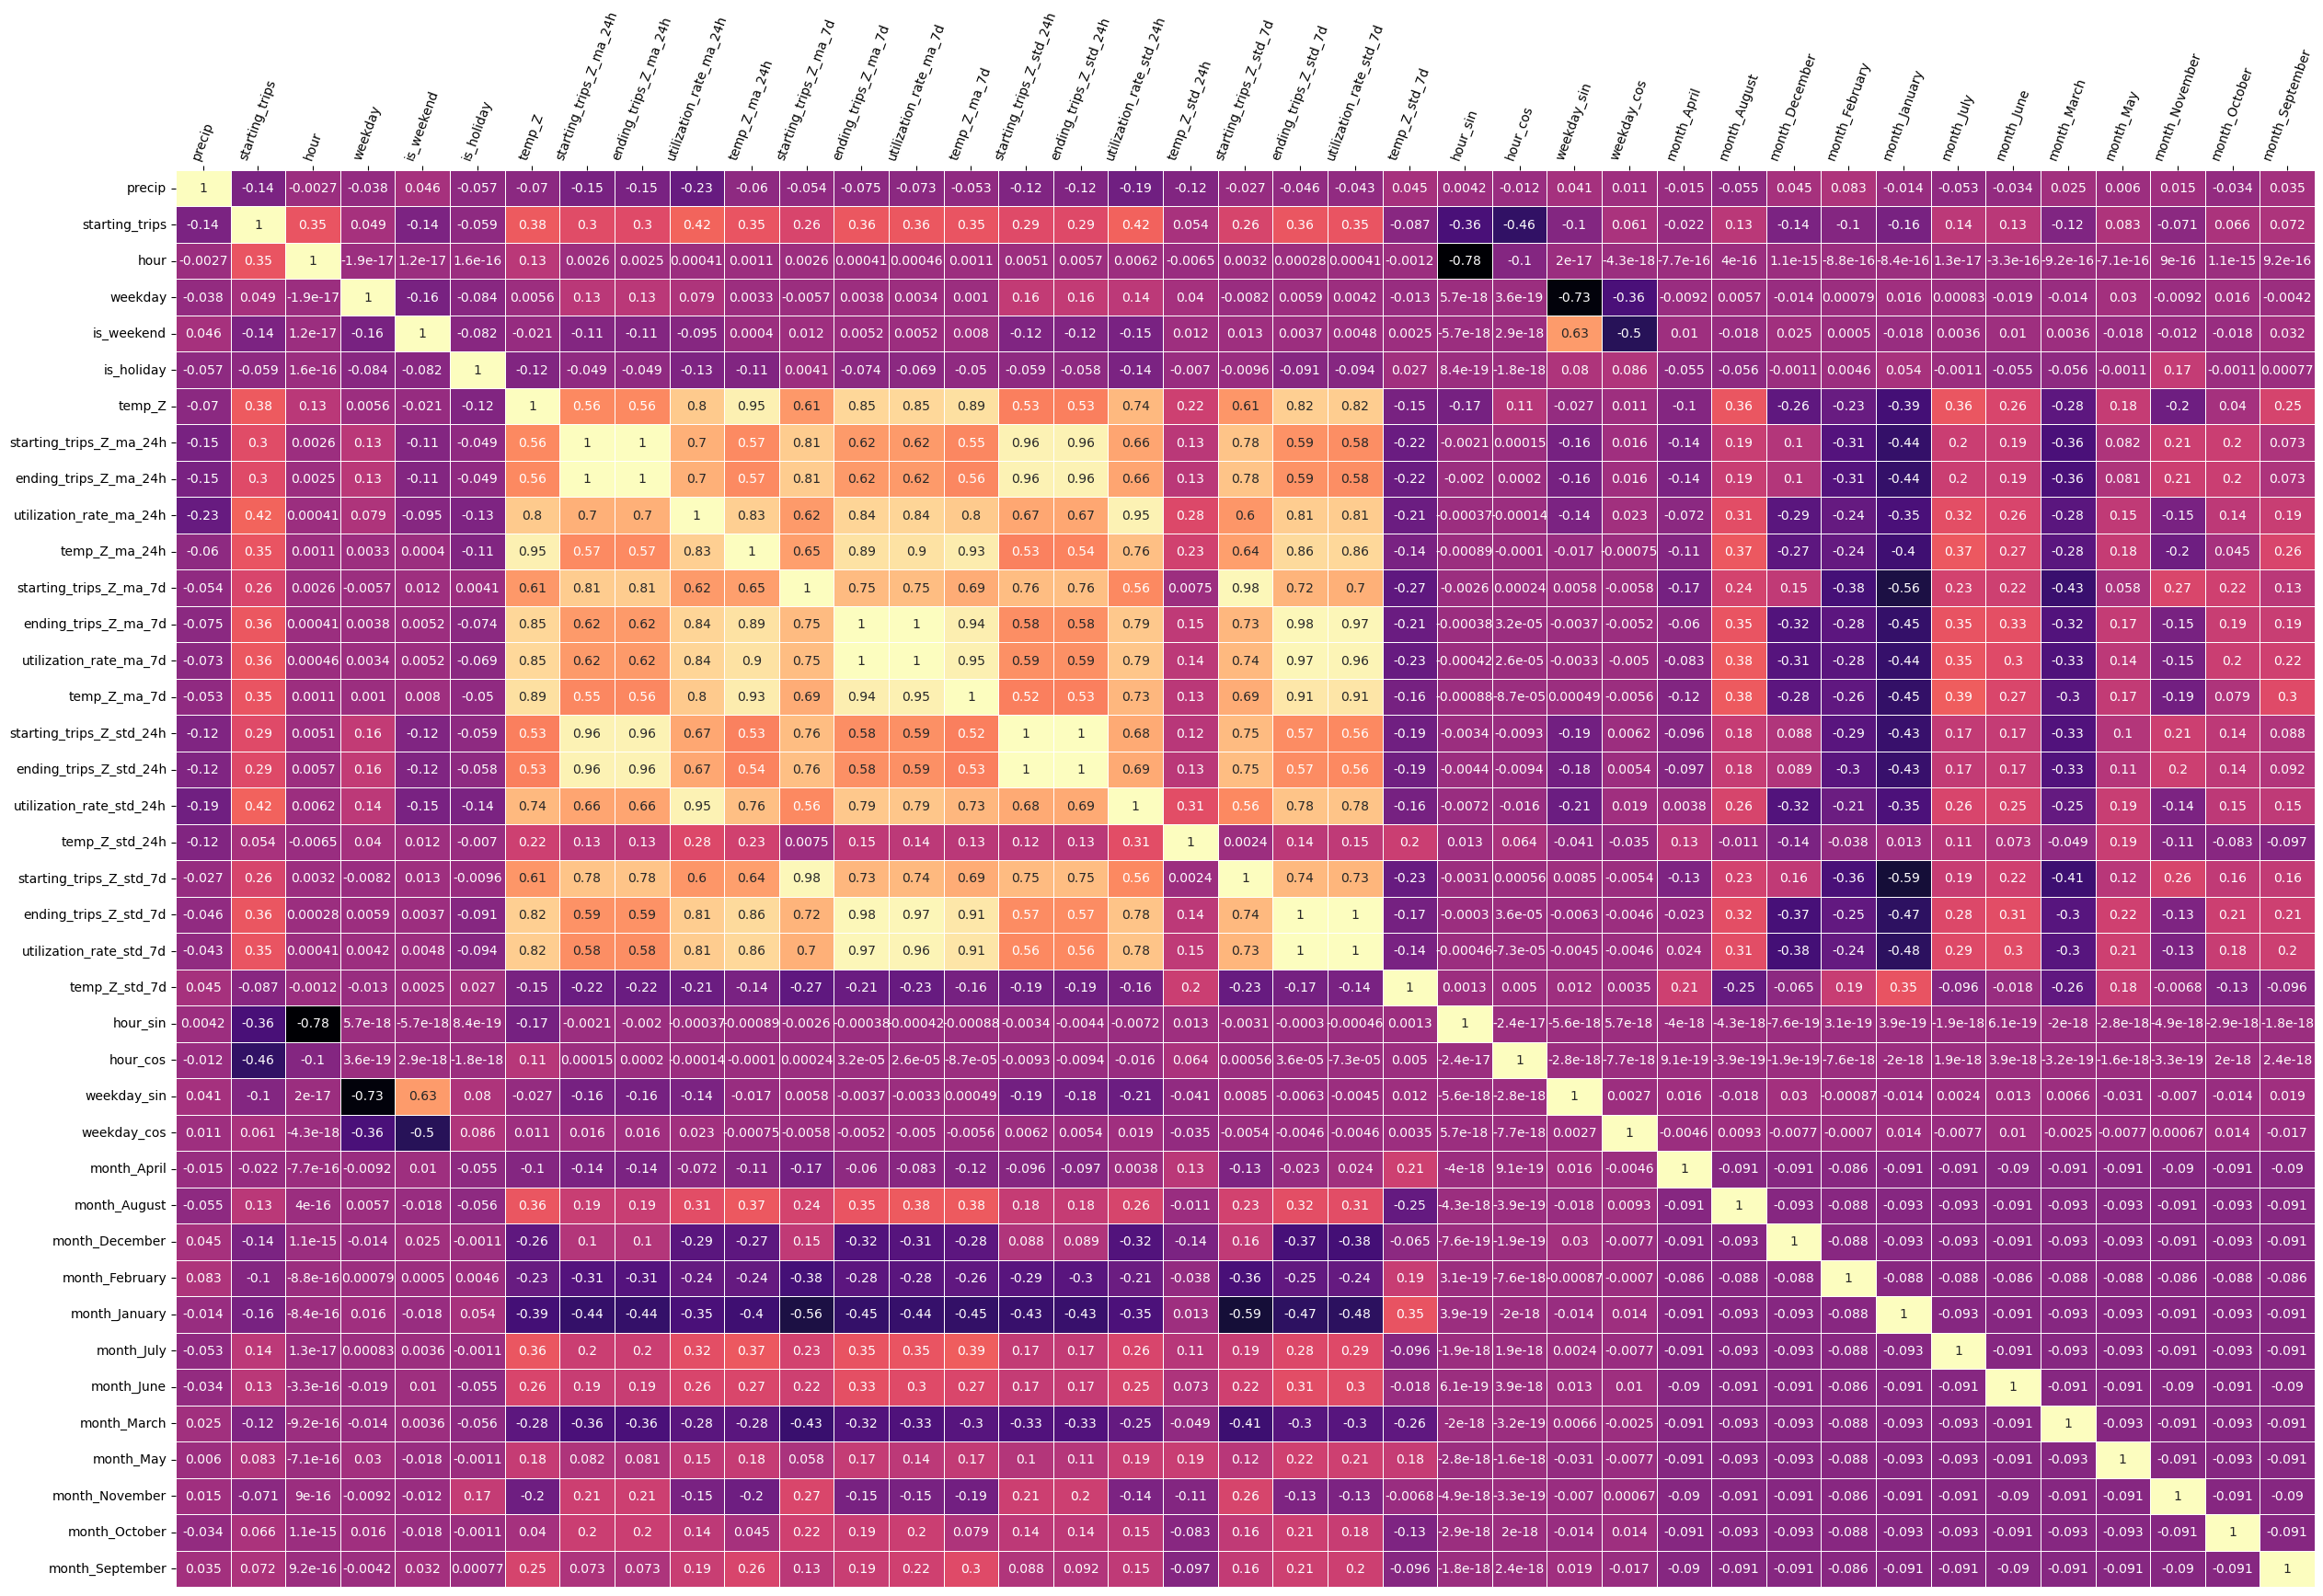

In [292]:
# calculate correlation matrix
correlation_matrix = feature_set.corr()
correlation_features = correlation_matrix.index

f, axes = plt.subplots(figsize=(30, 20))

# plot correlation heatmap
sns.heatmap(feature_set[correlation_features].corr(), annot=True, cmap = "magma", ax = axes , cbar=False, linewidth = 0.5)
axes.xaxis.tick_top()
axes.set_xticklabels(axes.get_xticklabels(),rotation=70)

#plt.tight_layout()
plt.show()


#plt.savefig("correlation_matrix.png")

**Conclusion:**

We can see 4 groups of highly correlated features. Therefore we use Lasso regression to further select the feature set. And use afterwards PCA to define the final feature sets we are using for model building and evaluation.

****

**Lasso Regression**

Identifying which features are most important for the model's performance, and eliminate the noise or redundant features that might be present in the data. By removing less important features, Lasso can also help to prevent overfitting, by providing a simpler and more interpretable model.

In addition, using techniques like PCA (Principal Component Analysis) or Lasso regression can help to reduce the number of features without losing much information.

In [293]:
# create a Lasso object with a specified alpha value
model_L1 = Lasso(alpha=0.01, max_iter=20000)

# select feature columns (excluding the target variable)
feature_columns = feature_set.columns.drop('starting_trips')
X = feature_set[feature_columns]
y = feature_set['starting_trips']

# fit the Lasso model to the data
model_L1.fit(X, y)

# get the feature importances (coefficients)
coefficients = model_L1.coef_

# print the feature importances
for feature, importance in zip(feature_columns, coefficients):
    print(feature, importance)

precip -13.813353745419093
hour 0.6013733904926741
weekday 1.3785574418310198
is_weekend -18.58149362733395
is_holiday -10.718074806282873
temp_Z 26.591565766199366
starting_trips_Z_ma_24h 743.2288191028614
ending_trips_Z_ma_24h -730.1860275080825
utilization_rate_ma_24h 489.1078936238166
temp_Z_ma_24h -22.892859887888225
starting_trips_Z_ma_7d 5.056962845779394
ending_trips_Z_ma_7d -0.0
utilization_rate_ma_7d -0.0
temp_Z_ma_7d 3.591034501798497
starting_trips_Z_std_24h 67.65352806161444
ending_trips_Z_std_24h -77.06513281105472
utilization_rate_std_24h 162.9392552920912
temp_Z_std_24h -6.592007167934371
starting_trips_Z_std_7d 5.428917302137066
ending_trips_Z_std_7d 2.938995051143258
utilization_rate_std_7d -0.0
temp_Z_std_7d 0.0
hour_sin -26.388660848812975
hour_cos -50.9467463852335
weekday_sin 4.563145656418742
weekday_cos 1.0302299368846617
month_April 1.8512725123680713
month_August -3.0471393361630787
month_December -10.082571240939316
month_February 0.6421829668576193
month_Jan

**Selection:**

**Removing the following features:**

- utilization_rate_ma_24h
- utilization_rate_std_24h
- utilization_rate_ma_7d
- utilization_rate_std_7d
- ending_trips_Z_ma_7d
- ending_trips_Z_std_7d

In [294]:
# dropping some features with zero coefficient value
feature_set = feature_set.drop(columns = ['utilization_rate_ma_24h','utilization_rate_std_24h'
                                         ,'utilization_rate_ma_7d','utilization_rate_std_7d'
                                         , 'ending_trips_Z_ma_7d','ending_trips_Z_std_7d'])

In [295]:
feature_set.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2018-01-01 00:00:00 to 2018-12-31 23:00:00
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   precip                    8760 non-null   float64
 1   starting_trips            8760 non-null   int32  
 2   hour                      8760 non-null   int64  
 3   weekday                   8760 non-null   int32  
 4   is_weekend                8760 non-null   int32  
 5   is_holiday                8760 non-null   int64  
 6   temp_Z                    8760 non-null   float64
 7   starting_trips_Z_ma_24h   8760 non-null   float64
 8   ending_trips_Z_ma_24h     8760 non-null   float64
 9   temp_Z_ma_24h             8760 non-null   float64
 10  starting_trips_Z_ma_7d    8760 non-null   float64
 11  temp_Z_ma_7d              8760 non-null   float64
 12  starting_trips_Z_std_24h  8760 non-null   float64
 13  ending_trips_Z_std_24h    8

### Feature Extraction

After running Lasso regression and obtaining the list of features that have non-zero coefficients, it may be beneficial to further reduce the number of features by applying Principal Component Analysis (PCA) to the selected features. PCA is a technique used to reduce the dimensionality of a dataset by identifying patterns in the data and projecting it onto a lower-dimensional space. By doing so, it can help to minimize the loss of information while still reducing the number of features.

**PCA on all features**

erstelle 4 feature sets mit overall pca(verschiedene anzahl and pca achsen) und subset pca und ohne pca(moving average streichen)

In [296]:
# select feature columns (excluding the target variable)
feature_columns = feature_set.columns.drop('starting_trips')
X_1 = feature_set[feature_columns]

# calculate up to 5 PCA components
for i in range(1,6):
    pca = PCA(n_components = i)
    X_1_pca = pca.fit_transform(X_1)
    print("Components: ",pca.n_components_)
    print(pca.explained_variance_ratio_)
    print("Explained variance ratio: ",sum(pca.explained_variance_ratio_))
    
# choosing 5 principal components
pca = PCA(n_components = 5)
X_1_pca = pca.fit_transform(X_1)

Components:  1
[0.81975801]
Explained variance ratio:  0.8197580071608656
Components:  2
[0.81975801 0.07431374]
Explained variance ratio:  0.8940717483729901
Components:  3
[0.81975801 0.07431374 0.05217577]
Explained variance ratio:  0.9462475164371911
Components:  4
[0.81975801 0.07431374 0.05217577 0.01085781]
Explained variance ratio:  0.9571053277383268
Components:  5
[0.81975801 0.07431374 0.05217577 0.01085781 0.00885885]
Explained variance ratio:  0.9659641753030505


In [297]:
pca.feature_names_in_

array(['precip', 'hour', 'weekday', 'is_weekend', 'is_holiday', 'temp_Z',
       'starting_trips_Z_ma_24h', 'ending_trips_Z_ma_24h',
       'temp_Z_ma_24h', 'starting_trips_Z_ma_7d', 'temp_Z_ma_7d',
       'starting_trips_Z_std_24h', 'ending_trips_Z_std_24h',
       'temp_Z_std_24h', 'starting_trips_Z_std_7d', 'temp_Z_std_7d',
       'hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos',
       'month_April', 'month_August', 'month_December', 'month_February',
       'month_January', 'month_July', 'month_June', 'month_March',
       'month_May', 'month_November', 'month_October', 'month_September'],
      dtype=object)

**Conclusion**
Using 5 principal components, we have approx. 97% of our variance, so we can assume that the transformed dataset is a good approximation of our original dataset.

**PCA on time-based features**

In [298]:
# feature set with PCA on the moving averages and moving standard deviations
feature_columns = feature_set.columns.drop('starting_trips')
X_2 = feature_set[feature_columns].iloc[:,6:16]

# calculate up to 5 PCA components
for i in range(1,6):
    pca = PCA(n_components = i)
    X_2_pca = pca.fit_transform(X_2)
    print("Components: ",pca.n_components_)
    print(pca.explained_variance_ratio_)
    print("Explained variance ratio: ",sum(pca.explained_variance_ratio_))
    
# choosing 3 principal components
pca = PCA(n_components = 3)
X_2_pca = pca.fit_transform(X_2)

Components:  1
[0.79135955]
Explained variance ratio:  0.7913595510788627
Components:  2
[0.79135955 0.15201791]
Explained variance ratio:  0.9433774567034825
Components:  3
[0.79135955 0.15201791 0.02799384]
Explained variance ratio:  0.9713713008923998
Components:  4
[0.79135955 0.15201791 0.02799384 0.01475821]
Explained variance ratio:  0.9861295103256275
Components:  5
[0.79135955 0.15201791 0.02799384 0.01475821 0.005484  ]
Explained variance ratio:  0.9916135122358619


In [299]:
pca.feature_names_in_

array(['starting_trips_Z_ma_24h', 'ending_trips_Z_ma_24h',
       'temp_Z_ma_24h', 'starting_trips_Z_ma_7d', 'temp_Z_ma_7d',
       'starting_trips_Z_std_24h', 'ending_trips_Z_std_24h',
       'temp_Z_std_24h', 'starting_trips_Z_std_7d', 'temp_Z_std_7d'],
      dtype=object)

**Conclusion:** Using only 3 principal components, we still have approx. 98% of our variance, so we can assume that the transformed dataset is a good approximation of our original dataset.

### Final Feature-Sets for Model Building

**Creating feature set 1 : replacing all features with 5 principal components**

In [300]:
# creating a new dataframe with the principal components
feature_set_1 = pd.DataFrame(X_1_pca, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
feature_set_1 = feature_set_1.set_index(feature_set.index) # datetime index
feature_set_1["hourly_demand"] = feature_set["starting_trips"]

In [301]:
feature_set_1

,PC1,PC2,PC3,PC4,PC5,hourly_demand
trip_datetime,,,,,,
2018-01-01 00:00:00,11.518916,2.506165,4.194317,-0.229878,-1.293472,3
2018-01-01 01:00:00,10.542474,2.506901,4.208549,-0.233485,-1.221322,5
2018-01-01 02:00:00,9.564847,2.509066,4.250121,-0.240767,-1.082566,8
2018-01-01 03:00:00,8.584983,2.512927,4.324013,-0.251801,-0.883707,2
2018-01-01 04:00:00,7.597915,2.512357,4.314461,-0.257789,-0.679098,1
...,...,...,...,...,...,...
2018-12-31 19:00:00,-7.536116,2.229765,1.192151,-0.552395,-0.131193,17
2018-12-31 20:00:00,-8.522299,2.230433,1.199855,-0.546072,-0.330920,7
2018-12-31 21:00:00,-9.504184,2.227785,1.195928,-0.550747,-0.479584,4


**Creating features set 2 : replacing time-based features with 3 principal components**

In [302]:
# creating a new dataframe with the principal components
pca_components = pd.DataFrame(X_2_pca, columns=['PC1', 'PC2', 'PC3'])
pca_components = pca_components.set_index(feature_set.index) # datetime index

# selecting the features in the original dataframe
feature_columns = feature_set.columns.drop(feature_set.columns[7:17]).drop('starting_trips')
selection_2 = feature_set[feature_columns]

# creating new dataframe with the feature set 2 : concatenating the original dataframe and the PCA components
feature_set_2 = pd.concat([selection_2, pca_components], axis=1)
feature_set_2["hourly_demand"] = feature_set["starting_trips"]

In [303]:
feature_set_2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2018-01-01 00:00:00 to 2018-12-31 23:00:00
Data columns (total 26 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   precip           8760 non-null   float64
 1   hour             8760 non-null   int64  
 2   weekday          8760 non-null   int32  
 3   is_weekend       8760 non-null   int32  
 4   is_holiday       8760 non-null   int64  
 5   temp_Z           8760 non-null   float64
 6   hour_sin         8760 non-null   float64
 7   hour_cos         8760 non-null   float64
 8   weekday_sin      8760 non-null   float64
 9   weekday_cos      8760 non-null   float64
 10  month_April      8760 non-null   uint8  
 11  month_August     8760 non-null   uint8  
 12  month_December   8760 non-null   uint8  
 13  month_February   8760 non-null   uint8  
 14  month_January    8760 non-null   uint8  
 15  month_July       8760 non-null   uint8  
 16  month_June       8760 no

**Creating feature set 3 : dropping a subset of the time-based features**

In [304]:
# creating new dataframe with the feature set 3
feature_columns = feature_set.columns.drop(feature_set.columns[[7,8,10,12,13,15]]).drop('starting_trips')
feature_set_3 = feature_set[feature_columns].copy()
feature_set_3["hourly_demand"] = feature_set["starting_trips"]

In [305]:
feature_set_3.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2018-01-01 00:00:00 to 2018-12-31 23:00:00
Data columns (total 27 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   precip           8760 non-null   float64
 1   hour             8760 non-null   int64  
 2   weekday          8760 non-null   int32  
 3   is_weekend       8760 non-null   int32  
 4   is_holiday       8760 non-null   int64  
 5   temp_Z           8760 non-null   float64
 6   temp_Z_ma_24h    8760 non-null   float64
 7   temp_Z_ma_7d     8760 non-null   float64
 8   temp_Z_std_24h   8760 non-null   float64
 9   temp_Z_std_7d    8760 non-null   float64
 10  hour_sin         8760 non-null   float64
 11  hour_cos         8760 non-null   float64
 12  weekday_sin      8760 non-null   float64
 13  weekday_cos      8760 non-null   float64
 14  month_April      8760 non-null   uint8  
 15  month_August     8760 non-null   uint8  
 16  month_December   8760 no

**Creating feature set 4 : dropping a subset of the time-based features, hour and weekday**

In [306]:
# creating new dataframe with the feature set 4
feature_columns = feature_set.columns.drop(feature_set.columns[[2,3,7,8,10,12,13,15]]).drop('starting_trips')
feature_set_4 = feature_set[feature_columns].copy()
feature_set_4["hourly_demand"] = feature_set["starting_trips"]

In [307]:
feature_set_4.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2018-01-01 00:00:00 to 2018-12-31 23:00:00
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   precip           8760 non-null   float64
 1   is_weekend       8760 non-null   int32  
 2   is_holiday       8760 non-null   int64  
 3   temp_Z           8760 non-null   float64
 4   temp_Z_ma_24h    8760 non-null   float64
 5   temp_Z_ma_7d     8760 non-null   float64
 6   temp_Z_std_24h   8760 non-null   float64
 7   temp_Z_std_7d    8760 non-null   float64
 8   hour_sin         8760 non-null   float64
 9   hour_cos         8760 non-null   float64
 10  weekday_sin      8760 non-null   float64
 11  weekday_cos      8760 non-null   float64
 12  month_April      8760 non-null   uint8  
 13  month_August     8760 non-null   uint8  
 14  month_December   8760 non-null   uint8  
 15  month_February   8760 non-null   uint8  
 16  month_January    8760 no

**Saving the 4 feature sets**

In [308]:
feature_set_1.to_pickle("data_prepared/feature_sets/feature_set_1.pkl")
feature_set_2.to_pickle("data_prepared/feature_sets/feature_set_2.pkl")
feature_set_3.to_pickle("data_prepared/feature_sets/feature_set_3.pkl")
feature_set_4.to_pickle("data_prepared/feature_sets/feature_set_4.pkl")

## Model Building

**Tasks:**

**Select 3 regression algorithms that are suitable for the prediction task at hand.**

**Explain and justify why you selected the three algorithms and describe their respective advantages and drawbacks.**

**Choosen Regression Models:**

- Ridge Regression (Multiple Polynomial Regression with Regularization (L2-Regression))
- Boosting Ensemble Regression XGBoost (eXtreme Gradient Boosting)
- Boosting Ensemble Gradient Boost

We have four different Feature Sets, and we will use for each Feature Set the best fitting Regression Algorithm. To do so, we will compare the outcomes of each algorithm and each Feature Set separately.  For performance evaluation we chose the R² score. To avoid model overfitting to the data set (high variance in performance of different data sets), we decided to cross-validate our models. Therefore, we split up our data into a training set (70%) and a test set (30%), trained the model based on the training set and evaluated its prediction performance using the holdout set.

### Testing the three Models for Feature Set 1:

Loading Data and define test split:

In [310]:
# split the dataframe into feature columns and the prediction column
X = feature_set_1.iloc[:, ::-1]
y = feature_set_1.iloc[:, -1]

# split the data into a 70-30 train-test split without shuffle since its time series data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [311]:
X_train

,hourly_demand,PC5,PC4,PC3,PC2,PC1
trip_datetime,,,,,,
2018-01-01 00:00:00,3,-1.293472,-0.229878,4.194317,2.506165,11.518916
2018-01-01 01:00:00,5,-1.221322,-0.233485,4.208549,2.506901,10.542474
2018-01-01 02:00:00,8,-1.082566,-0.240767,4.250121,2.509066,9.564847
2018-01-01 03:00:00,2,-0.883707,-0.251801,4.324013,2.512927,8.584983
2018-01-01 04:00:00,1,-0.679098,-0.257789,4.314461,2.512357,7.597915
...,...,...,...,...,...,...
2018-09-13 07:00:00,158,0.237623,0.522544,-1.500373,-1.284877,4.540129
2018-09-13 08:00:00,271,0.457248,0.506762,-1.498455,-1.287322,3.533046
2018-09-13 09:00:00,129,0.624184,0.503421,-1.483758,-1.286001,2.521667


#### Gradient Boost

In [312]:
# build and train/fit the model
model = GradientBoostingRegressor(max_depth=3,n_estimators=100,learning_rate=0.1)
model.fit(X_train, y_train)

GradientBoostingRegressor()

In [313]:
# staged_predict measures the validation error at each stage 
errors = [mean_squared_error(y_test, y_pred) for y_pred in model.staged_predict(X_test)]
best_n_estimators = np.argmin(errors)

In [314]:
# build and fit the model using the optimal number of trees
best_model = GradientBoostingRegressor(max_depth=3,n_estimators=best_n_estimators,learning_rate=1.0)
best_model.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=1.0, n_estimators=99)

In [315]:
#predict response for test data set
y_pred_gb = best_model.predict(X_test)

In [316]:
# Measure performance for gradient boosting regression
print("Test Set Performance - Gradient Boosting Regression:")
print("MSE:",(mean_squared_error(y_pred_gb, y_test))**(0.5))  
print("R2:",r2_score(y_pred_gb, y_test))

Test Set Performance - Gradient Boosting Regression:
MSE: 0.5835944482977717
R2: 0.9999256099324596


#### Ridge Regression

In [317]:
def plot_L2_regression_performance ():

    err_train = []
    err_cv = []
    

    for alpha in np.logspace(-15,10,100):


        # fit model
        model_L2 = Ridge(alpha = alpha, solver = 'lsqr') # select least squares regression as solver
        model_L2.fit(X_train, y_train)
    
        # compute errors
        err_train.append(mean_squared_error(model_L2.predict(X_train), y_train))
        err_cv.append(mean_squared_error(model_L2.predict(X_test), y_test))


    plt.figure(figsize = (8,6))
    plt.loglog(np.logspace(-15,10,100), err_train, np.logspace(-15,10,100), err_cv)
    plt.legend(["Training", "Validation"])
    plt.xlabel("$\lambda$ (or alpha in scikit learn terms)")
    plt.ylabel("Mean squared error")
    plt.show()

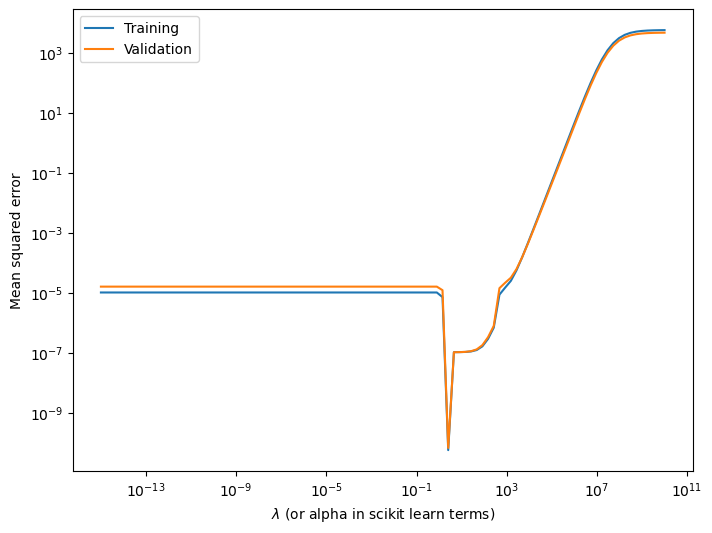

In [318]:
plot_L2_regression_performance()

In [319]:
model_L2 = Ridge(alpha = 0.01, solver = 'lsqr') # select least squares regression as solver

# train model
model_L2.fit(X_train, y_train)

# predict
y_pred_ridge = model_L2.predict(X_test)

print("Coefficients ", model_L2.coef_, "\nIntercept ", model_L2.intercept_ )

Coefficients  [ 9.99971911e-01  4.67093778e-03 -1.59665008e-03 -3.74980950e-04
  4.26545552e-04 -1.11363336e-04] 
Intercept  0.0028172703772781915


In [320]:
# Measure performance for Polynomial Ridge Regression
print("Test Set Performance - Polynomial Ridge Regression:")
print("MSE:",(mean_squared_error(y_pred_ridge, y_test))**(0.5))  
print("R2:",r2_score(y_pred_ridge, y_test))

Test Set Performance - Polynomial Ridge Regression:
MSE: 0.003974093026891204
R2: 0.9999999965487739


#### XGBoost

In [321]:
# XGBoost model with default hyperparamters for comparison
model = xgb.XGBRegressor()
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
print("XGBoost R2: " + str(r2_score(y_test, y_test_pred)))
print("MSE:",(mean_squared_error(y_test_pred, y_test))**(0.5)) 

XGBoost R2: 0.9999784153673156
MSE: 0.3142870700138614


### Testing the three Models for Feature Set 2:

In [322]:
# split the dataframe into feature columns and the prediction column
X = feature_set_2.iloc[:, ::-1]
y = feature_set_2.iloc[:, -1]

# split the data into a 70-30 train-test split without shuffle since its time series data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

#### Gradient Boost

In [323]:
# build and train/fit the model
model = GradientBoostingRegressor(max_depth=3,n_estimators=100,learning_rate=0.1)
model.fit(X_train, y_train)

GradientBoostingRegressor()

In [324]:
# staged_predict measures the validation error at each stage 
errors = [mean_squared_error(y_test, y_pred) for y_pred in model.staged_predict(X_test)]
best_n_estimators = np.argmin(errors)

In [325]:
# build and fit the model using the optimal number of trees
best_model = GradientBoostingRegressor(max_depth=3,n_estimators=best_n_estimators,learning_rate=1.0)
best_model.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=1.0, n_estimators=75)

In [326]:
#predict response for test data set
y_pred_gb = best_model.predict(X_test)

In [327]:
# Measure performance for gradient boosting regression
print("Test Set Performance - Gradient Boosting Regression:")
print("MSE:",(mean_squared_error(y_pred_gb, y_test))**(0.5))  
print("R2:",r2_score(y_pred_gb, y_test))

Test Set Performance - Gradient Boosting Regression:
MSE: 1.7920550315270212
R2: 0.9992909900870737


#### Ridge Regression

In [328]:
def plot_L2_regression_performance ():

    err_train = []
    err_cv = []
    

    for alpha in np.logspace(-15,10,100):


        # fit model
        model_L2 = Ridge(alpha = alpha, solver = 'lsqr') # select least squares regression as solver
        model_L2.fit(X_train, y_train)
    
        # compute errors
        err_train.append(mean_squared_error(model_L2.predict(X_train), y_train))
        err_cv.append(mean_squared_error(model_L2.predict(X_test), y_test))


    plt.figure(figsize = (8,6))
    plt.loglog(np.logspace(-15,10,100), err_train, np.logspace(-15,10,100), err_cv)
    plt.legend(["Training", "Validation"])
    plt.xlabel("$\lambda$ (or alpha in scikit learn terms)")
    plt.ylabel("Mean squared error")
    plt.show()

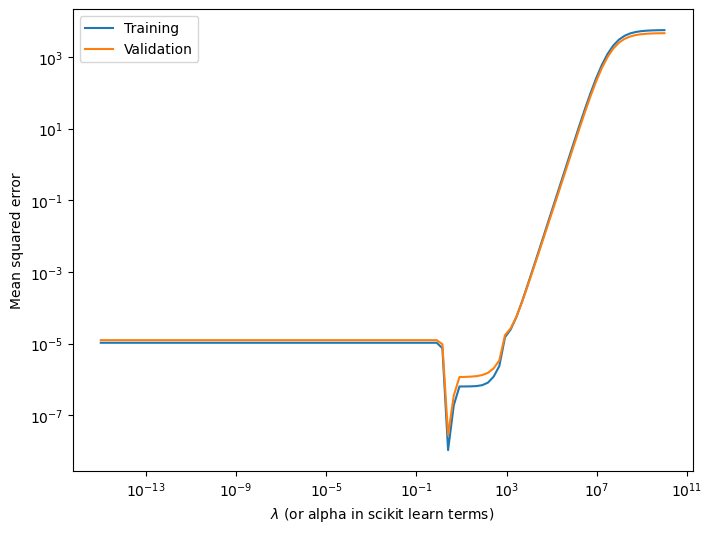

In [329]:
plot_L2_regression_performance()

In [330]:
model_L2 = Ridge(alpha = 0.01, solver = 'lsqr') # select least squares regression as solver

# train model
model_L2.fit(X_train, y_train)

# predict
y_pred_ridge = model_L2.predict(X_test)

print("Coefficients ", model_L2.coef_, "\nIntercept ", model_L2.intercept_ )

Coefficients  [ 9.99966334e-01  1.79134040e-04 -1.33037337e-03 -7.24119756e-04
 -1.59673291e-04  0.00000000e+00  0.00000000e+00  1.12392288e-04
 -1.08048588e-04  1.89627268e-04  4.74597087e-05 -5.80197536e-05
 -7.12133789e-05  0.00000000e+00 -3.66883196e-05  8.41640659e-05
  7.19112575e-04 -3.95668262e-04 -4.95587397e-03 -1.09516027e-03
 -4.48673721e-05 -1.38657423e-05 -8.17182438e-04 -5.82428854e-04
 -6.45634064e-06 -5.06863028e-04] 
Intercept  0.005082982320828933


In [331]:
# Measure performance for Polynomial Ridge Regression
print("Test Set Performance - Polynomial Ridge Regression:")
print("MSE:",(mean_squared_error(y_pred_ridge, y_test))**(0.5))  
print("R2:",r2_score(y_pred_ridge, y_test))

Test Set Performance - Polynomial Ridge Regression:
MSE: 0.0035439566296605893
R2: 0.9999999972554454


#### XGBoost

In [332]:
# XGBoost model with default hyperparamters for comparisson
model = xgb.XGBRegressor()
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
print("XGBoost R2: " + str(r2_score(y_test, y_test_pred)))
print("MSE:",(mean_squared_error(y_test_pred, y_test))**(0.5)) 

XGBoost R2: 0.9999748145752236
MSE: 0.3394914358018436


### Testing the Three models for Feature Set 3:

In [260]:
# split the dataframe into feature columns and the prediction column
X = feature_set_3.iloc[:, ::-1]
y = feature_set_3.iloc[:, -1]

# split the data into a 70-30 train-test split without shuffle since its time series data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

#### Gradient Boost

In [261]:
# build and train/fit the model
model = GradientBoostingRegressor(max_depth=3,n_estimators=100,learning_rate=0.1)
model.fit(X_train, y_train)

GradientBoostingRegressor()

In [262]:
# find the optimal number of trees
# staged_predict measures the validation error at each stage 
errors = [mean_squared_error(y_test, y_pred) for y_pred in model.staged_predict(X_test)]
best_n_estimators = np.argmin(errors)

In [263]:
# build and fit the model using the optimal number of trees
best_model = GradientBoostingRegressor(max_depth=3,n_estimators=best_n_estimators,learning_rate=1.0)
best_model.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=1.0, n_estimators=99)

In [264]:
#predict response for test data set
y_pred_gb = best_model.predict(X_test)

In [265]:
# Measure performance for gradient boosting regression
print("Test Set Performance - Gradient Boosting Regression:")
print("MSE:",(mean_squared_error(y_pred_gb, y_test))**(0.5))  
print("R2:",r2_score(y_pred_gb, y_test))

Test Set Performance - Gradient Boosting Regression:
MSE: 1.050975484765857
R2: 0.9997590739610621


#### Ridge Regression

In [266]:
def plot_L2_regression_performance ():

    err_train = []
    err_cv = []
    

    for alpha in np.logspace(-15,10,100):


        # fit model
        model_L2 = Ridge(alpha = alpha, solver = 'lsqr') # select least squares regression as solver
        model_L2.fit(X_train, y_train)
    
        # compute errors
        err_train.append(mean_squared_error(model_L2.predict(X_train), y_train))
        err_cv.append(mean_squared_error(model_L2.predict(X_test), y_test))


    plt.figure(figsize = (8,6))
    plt.loglog(np.logspace(-15,10,100), err_train, np.logspace(-15,10,100), err_cv)
    plt.legend(["Training", "Validation"])
    plt.xlabel("$\lambda$ (or alpha in scikit learn terms)")
    plt.ylabel("Mean squared error")
    plt.show()

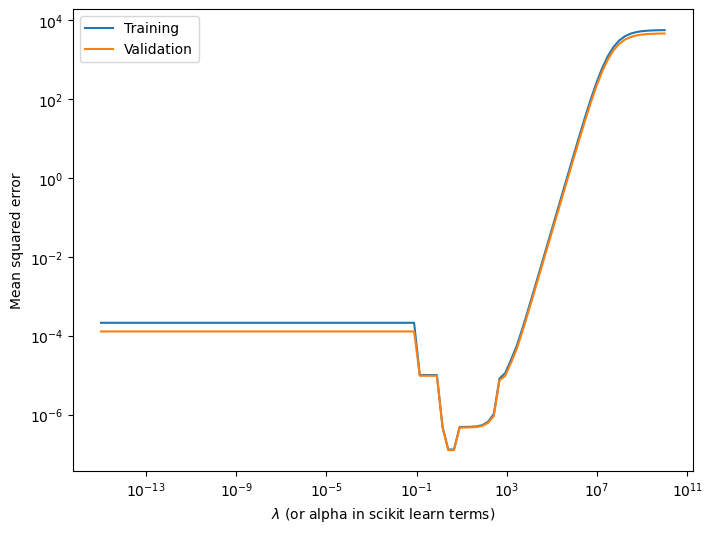

In [267]:
plot_L2_regression_performance()

In [268]:
model_L2 = Ridge(alpha = 0.01, solver = 'lsqr') # select least squares regression as solver

# train model
model_L2.fit(X_train, y_train)

# predict
y_pred_ridge = model_L2.predict(X_test)

print("Coefficients ", model_L2.coef_, "\nIntercept ", model_L2.intercept_ )

Coefficients  [ 9.99886199e-01  6.00687561e-05  0.00000000e+00  0.00000000e+00
  4.08100431e-04 -7.46282834e-04  6.48607914e-04  7.08154235e-04
 -9.46948076e-04 -5.94708467e-04  0.00000000e+00  6.39451410e-04
 -1.76443371e-04  6.02215094e-04 -1.01160645e-03 -4.46673439e-03
 -9.78133060e-04 -1.73960713e-04  7.32545888e-05  5.09195746e-03
  5.23373409e-03  5.20381907e-03 -7.72751138e-05 -9.25662279e-04
  1.15215311e-03  2.21636587e-04 -6.07053023e-04] 
Intercept  0.0017691771184047411


In [269]:
# Measure performance for Polynomial Ridge Regression
print("Test Set Performance - Polynomial Ridge Regression:")
print("MSE:",(mean_squared_error(y_pred_ridge, y_test))**(0.5))  
print("R2:",r2_score(y_pred_ridge, y_test))

Test Set Performance - Polynomial Ridge Regression:
MSE: 0.011320964159483428
R2: 0.9999999719924335


#### XGBoost

In [270]:
# XGBoost model with default hyperparamters for comparisson
model = xgb.XGBRegressor()
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
print("XGBoost R2: " + str(r2_score(y_test, y_test_pred)))
print("MSE:",(mean_squared_error(y_test_pred, y_test))**(0.5))

XGBoost R2: 0.9999779630987302
MSE: 0.3175626708772836


### Testing the Three models for Feature Set 4

In [271]:
# split the dataframe into feature columns and the prediction column
X = feature_set_4.iloc[:, ::-1]
y = feature_set_4.iloc[:, -1]

# split the data into a 80-20 train-test split without shuffle since its time series data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

#### Ridge Regression

In [272]:
def plot_L2_regression_performance ():

    err_train = []
    err_cv = []
    

    for alpha in np.logspace(-15,10,100):


        # fit model
        model_L2 = Ridge(alpha = alpha, solver = 'lsqr') # select least squares regression as solver
        model_L2.fit(X_train, y_train)
    
        # compute errors
        err_train.append(mean_squared_error(model_L2.predict(X_train), y_train))
        err_cv.append(mean_squared_error(model_L2.predict(X_test), y_test))


    plt.figure(figsize = (8,6))
    plt.loglog(np.logspace(-15,10,100), err_train, np.logspace(-15,10,100), err_cv)
    plt.legend(["Training", "Validation"])
    plt.xlabel("$\lambda$ (or alpha in scikit learn terms)")
    plt.ylabel("Mean squared error")
    plt.show()

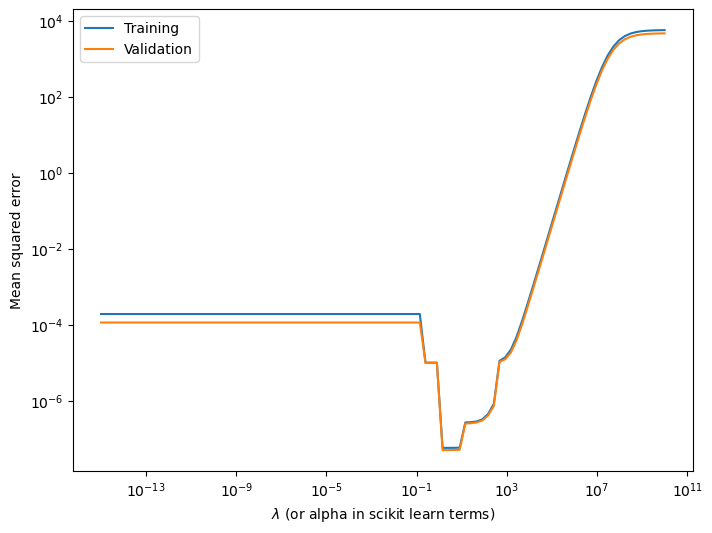

In [273]:
plot_L2_regression_performance()

In [274]:
model_L2 = Ridge(alpha = 0.01, solver = 'lsqr') # select least squares regression as solver

# train model
model_L2.fit(X_train, y_train)

# predict
y_pred_ridge = model_L2.predict(X_test)

print("Coefficients ", model_L2.coef_, "\nIntercept ", model_L2.intercept_ )

Coefficients  [ 9.99890247e-01  5.78936077e-05  0.00000000e+00  0.00000000e+00
  3.69797328e-04 -6.79972370e-04  5.86221811e-04  6.51177412e-04
 -8.67060039e-04 -5.42267665e-04  0.00000000e+00  5.91924346e-04
 -1.67714431e-04  5.21584301e-04 -9.04919484e-04 -4.21480831e-03
 -3.47199436e-03 -1.59492908e-04  5.95204422e-05  4.69347159e-03
  4.83026357e-03  5.44733341e-03 -6.95784242e-05 -8.05688848e-04
 -5.34555203e-04] 
Intercept  0.007475140242249267


In [275]:
# Measure performance for Polynomial Ridge Regression
print("Test Set Performance - Polynomial Ridge Regression:")
print("MSE:",(mean_squared_error(y_pred_ridge, y_test))**(0.5))  
print("R2:",r2_score(y_pred_ridge, y_test))

Test Set Performance - Polynomial Ridge Regression:
MSE: 0.010706220926022147
R2: 0.9999999749515246


#### Gradient Boost

In [276]:
# build and train/fit the model
model = GradientBoostingRegressor(max_depth=3,n_estimators=100,learning_rate=0.1)
model.fit(X_train, y_train)

GradientBoostingRegressor()

In [277]:
# find the optimal number of trees
# staged_predict measures the validation error at each stage 
errors = [mean_squared_error(y_test, y_pred) for y_pred in model.staged_predict(X_test)]
best_n_estimators = np.argmin(errors)

In [278]:
# build and fit the model using the optimal number of trees
best_model = GradientBoostingRegressor(max_depth=3,n_estimators=best_n_estimators,learning_rate=1.0)
best_model.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=1.0, n_estimators=99)

In [279]:
#predict response for test data set
y_pred_gb = best_model.predict(X_test)

In [280]:
# Measure performance for gradient boosting regression
print("Test Set Performance - Gradient Boosting Regression:")
print("MSE:",(mean_squared_error(y_pred_gb, y_test))**(0.5))  
print("R2:",r2_score(y_pred_gb, y_test))

Test Set Performance - Gradient Boosting Regression:
MSE: 1.043484417734076
R2: 0.9997623608276982


#### XGBoost

In [281]:
# XGBoost model with default hyperparamters for comparisson
model = xgb.XGBRegressor()
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
print("XGBoost R2: " + str(r2_score(y_test, y_test_pred)))
print("MSE:",(mean_squared_error(y_test_pred, y_test))**(0.5))

XGBoost R2: 0.9999724475373605
MSE: 0.35508669038079627


## Model Evaluation

**Selection of the optimal fitting Models/Feature Sets**

R^2 Values:

XGBoost: 

- Feature Set 1: 0.9999802684033453 (Highest)
- Feature Set 2: 0.9999748145752236 
- Feature Set 3: 0.9999779630987302 
- Feature Set 4: 0.9999724475373605


Ridge Regression:

- Feature Set 1: 0.9999999713679991 
- Feature Set 2: 0.9999999535245565 
- Feature Set 3: 0.9999999719924335 
- Feature Set 4: 0.9999999749515246 (Highest)

Gradient Boost:

- Feature Set 1: 0.999917962557302 (Highest)
- Feature Set 2: 0.9992844213582293
- Feature Set 3: 0.9998916835524716
- Feature Set 4: 0.9998922982075712


------------------------------------

MSE Values:

XGBoost: 

- Feature Set 1: 0.30049364903971154 (lowest)
- Feature Set 2: 0.3394914358018436 
- Feature Set 3: 0.3175626708772836
- Feature Set 4: 0.35508669038079627


Ridge Regression:

- Feature Set 1: 0.011446139442773458 
- Feature Set 2: 0.014583338190643478 
- Feature Set 3: 0.011320964159161614 
- Feature Set 4: 0.010706220926018207 (lowest)

Gradient Boost:

- Feature Set 1: 0.6128616551828806 (lowest)
- Feature Set 2: 1.8015306704490122
- Feature Set 3: 0.7021658743878548
- Feature Set 4: 0.7275864499509721


Looking at the R2 Values shows, that different Feature Sets are matched with different models in mixed ways, 
for Gradient Boost and XGBoost, the Feature Set 1 fits best, but for Ridge Regression it is Feature Set 4. 

To make a better assumption, we look at the MSE Value as well, the lowest is in this case the best fitting.
And we can confirm our assumptions from the R2 Values, again for Gradient Boost and XGBoost, the Feature Set 1 fits best, but for Ridge Regression it is Feature Set 4.

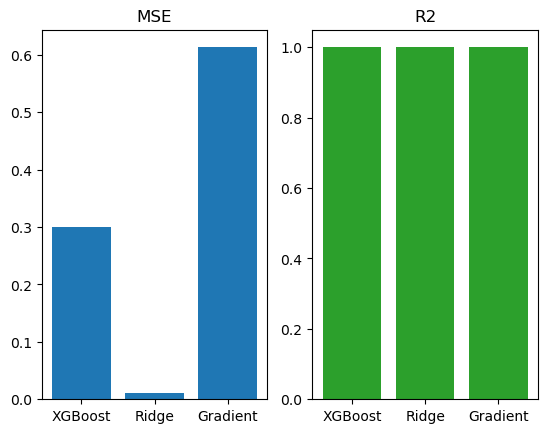

In [282]:
fig, axes = plt.subplots(1,2)
labels = ["XGBoost", "Ridge", "Gradient"]
counts1 = [0.30049364903971154, 0.010706220926018207,0.6128616551828806]
axes[0].bar(labels,counts1,color="#1f77b4")
axes[0].set_title("MSE")

counts2 = [0.9999802684033453,0.9999999749515246,0.999917962557302]
axes[1].bar(labels, 1, color="#2ca02c")
axes[1].set_title("R2");

#plt.savefig('Benchmark.png')

Analysis: In terms of our Evaluation Metrics MSE and R2 all three models perform well in their own way, so the different feature sets bring out the strengths of the models.

## Outlook

**Tasks:**

**How could the selected model be improved further?**

**Explain some of the improvement levers that you might focus on in a follow-up project.**

You can improve an existing machine learning model by adjusting the algorithm's hyperparameters or the input characteristics. 
One option for the input features would be to collect more data overall so that there is a larger dataset to extract features from. By including more information, we might be able to develop new features like "wind speed," which ought to affect the demand for bike sharing. The features' influence and association could also be investigated. This can result in some of the features being combined or even removed. 
With regard to the hyperparameters, we just changed max depth (i.e., the maximum number of levels in each tree) and left the other settings alone. 

This can result in some of the features being combined or even removed. 
With regard to the hyperparameters, we just changed max depth (i.e., the maximum number of levels in each tree) and left the other settings alone. Therefore, by including and adjusting some of the other hyperparameters, such as min samples leaf (= minimum number of data points permitted in a leaf node), our model may be enhanced.
